In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
from tensorflow import keras
import tensorflow as tf
import keras
from sklearn.model_selection import StratifiedKFold
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

In [2]:
train_image_path = '../input/uw-madison-gi-tract-image-segmentation/train/'
train_image_path = '../input/uw-madison-gi-tract-image-segmentation/test/'
df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
sample_submission  = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')
def get_case(row):
    return row.split("_")[0]
def get_day(row):
     return row.split("_")[1]
def get_slice(row):
     return row.split("_")[2] + row.split("_")[3]

path = '../input/uw-madison-gi-tract-image-segmentation/train'
train_image_paths = glob(os.path.join( path, '**','**' , '*' , '*.png'))
df['case'] = df['id'].apply(lambda x: get_case(x))
df['day'] = df['id'].apply(lambda x: get_day(x))
df['slice'] = df['id'].apply(lambda x: get_slice(x))
df_without = df[df['segmentation'].isna()]
df_with = df[~df['segmentation'].isna()]

In [3]:
def get_temp_path(temp):
    case = temp.split("_")[0]
    case_day = case + '_' + temp.split("_")[1]
    slice_ = temp.split("_")[-1]
    temp= path + '/' + case + '/'+ case_day + '/scans/slice_' + slice_ 
    return temp
df['temp_path'] = df['id'].apply(lambda x: get_temp_path(x))

In [4]:
def get_path_list(temp):
    one = '/'.join(map(str,temp.split("/")[0:-1])) + '/' + 'slice_'
    last  = temp.split("/")[-1].split("_")[1]
    final = one +last
    return final

temp_orginal_path = [get_path_list(i) for i in train_image_paths]
original_path_df = pd.DataFrame(train_image_paths , columns = ['original_path']) 
original_path_df['temp_path'] = temp_orginal_path
df = pd.merge(df, original_path_df, how='left', on ='temp_path')

In [5]:
def get_width(path):
    return path.split("/")[-1].split("_")[2]
def get_height(path):
    return path.split("/")[-1].split("_")[3]

df['width']= df['original_path'].apply(lambda x: get_width(x))
df['height']= df['original_path'].apply(lambda x: get_height(x))

2022-04-26 18:51:44.445782: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Cleanup called...


Image is getting loaded


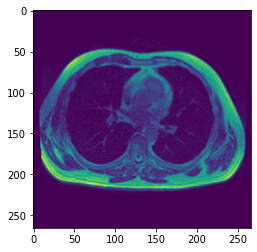

In [6]:
img = tf.io.read_file(df['original_path'][120])
img = tf.io.decode_jpeg(img)
print("Image is getting loaded")
plt.imshow(img)
plt.show()

In [7]:
def rle_decode(temp, shape):
    #print(type(temp))
    array = np.zeros(shape=shape)
    temp = temp.split(" ")
    array = array.reshape(-1)
    pixels = list(map(int, temp[0:-1:2]))
    distance = list(map(int,temp[1::2]))
    end = [ i+j for i, j in zip(pixels, distance)]
    for start,end_ in zip(pixels, end):
        array[start:end_]=1
    array = array.reshape(shape)
    return array

def rle_encode(arr):
    arr = arr.reshape(-1)
    indexes = (np.where(arr[1:] != arr[:-1])[0])+1
    final = []
    one = indexes[0:-1:2]
    two = indexes[1::2]
    for start,end in zip(one, two):
        final.append(start)
        final.append(end-start)
    return ' '.join(map(str,final))

In [8]:
#fixing the column level
final_df = pd.DataFrame({'id' : df['id'][::3]})
final_df['lb_seg'] = df['segmentation'][::3].values
final_df['sb_seg'] = df['segmentation'][1::3].values
final_df['st_seg'] =  df['segmentation'][2::3].values
final_df['case'] =  df['case'][::3].values
final_df['day'] =  df['day'][::3].values
final_df['slice'] =  df['slice'][::3].values
final_df['original_path'] =  df['original_path'][::3].values
final_df['width'] =  df['width'][::3].values
final_df['height'] =  df['height'][::3].values

In [9]:
train_indexes = []
df_train = final_df[~ (final_df['lb_seg'].isna() & final_df['sb_seg'].isna()  & final_df['st_seg'].isna() )]
df_train=df_train.reset_index(drop=True)

In [10]:
df_train = df_train.fillna('')

In [11]:
##Splitting
skf = StratifiedKFold(n_splits=5, shuffle=True)

for fold, (train_ids, valid_ids) in enumerate(skf.split(X=df_train, y=df_train['case'])):
    df_train.loc[valid_ids, 'fold'] = int(fold)

df_train.fold = df_train.fold.astype('int64')

select_fold = 1

train_ids = df_train[df_train['fold']!=select_fold].index
valid_ids = df_train[df_train['fold']==select_fold].index

In [12]:
class Segmentation_data(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, dim = (266,266), channels = 3, shuffle=True, train=True):
        self.df =df.copy()
        self.batch_size = batch_size
        self.dim=dim
        self.channels=channels
        self.shuffle= shuffle
        self.train = train
        self.on_epoch_end()
        
    def __getitem__(self, index):
        #print(index)
        X = np.empty(shape=(self.batch_size, self.dim[0], self.dim[1], self.channels))
        Y = np.empty(shape=(self.batch_size, self.dim[0], self.dim[1], self.channels))
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        #print(arr.shape)
        for i , ind in enumerate(indexes):
            img = self.__load_image(self.df.iloc[ind]['original_path'])
            X[i,]=img
            
            if(self.train):
                st_seg = np.zeros(shape=(self.dim[0], self.dim[1]))
                sb_seg = np.zeros(shape=(self.dim[0], self.dim[1]))
                lb_seg = np.zeros(shape=(self.dim[0], self.dim[1]))
                
                if(self.df.iloc[ind]['st_seg']!=''):
                    st_seg = rle_decode(self.df.iloc[ind]['st_seg'] ,(self.dim[0], self.dim[1]))
                    
                if(self.df.iloc[ind]['sb_seg']!=''):
                    sb_seg = rle_decode(self.df.iloc[ind]['sb_seg'] ,(self.dim[0], self.dim[1] ))
                    
                if(self.df.iloc[ind]['lb_seg']!=''):
                    lb_seg = rle_decode(self.df.iloc[ind]['lb_seg'] ,(self.dim[0], self.dim[1]))
                    
                #print(lb_seg.shape)
                
                Y[i,:,:,0] = lb_seg
                Y[i,:,:,1] = sb_seg
                Y[i,:,:,2] = st_seg
                
            if(self.train):
                return X, Y
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if(self.shuffle==True):
            np.random.shuffle(self.indexes)
        
    def __len__(self): #this returns the steps per epoch, (in 1 epoch, we send the entire data, so total size / batch size )
        return int(np.floor(len(self.df) / self.batch_size))
    
    
    def __load_image(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        img = cv2.resize(img, (266,266))
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

In [13]:
train_dataset = Segmentation_data(df_train.loc[train_ids], batch_size = 8)

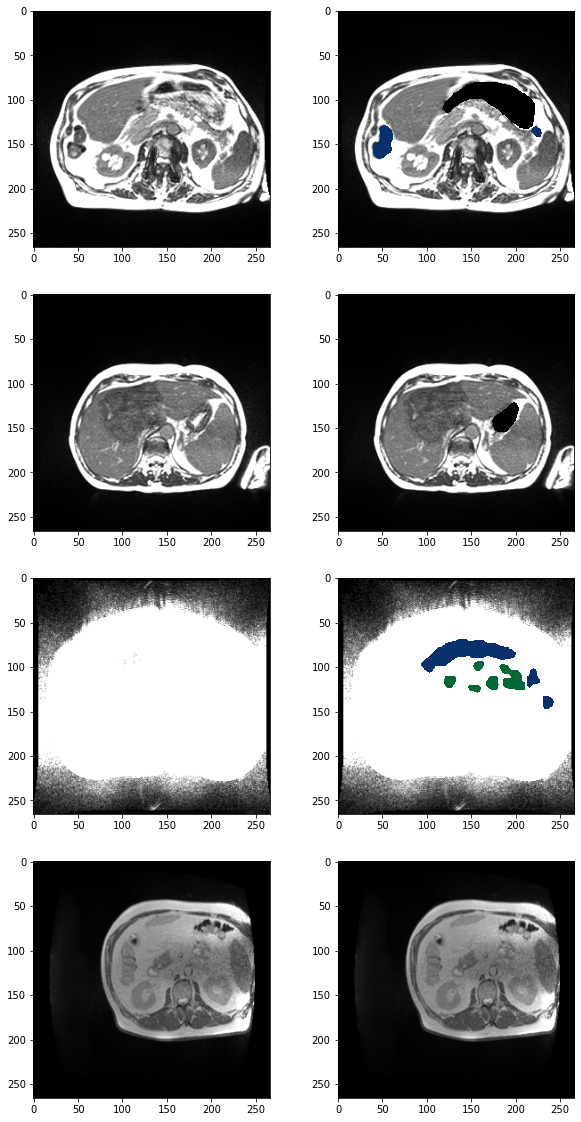

In [14]:
fig = plt.figure(figsize= (10,20))
gs = gridspec.GridSpec(4, 2)

for i in range(4):
    images, masks = train_dataset[i]
    image = images[0,]
    
    mask1 = masks[0,:,:,0]
    mask2 = masks[0,:,:,1]
    mask3 = masks[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i,0])
    ax1 = fig.add_subplot(gs[i,1])
    
    ax0.imshow(image)#,cmap='bone')
    
    l0 = ax1.imshow(image,cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap='Blues_r',alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap='RdYlGn_r',alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap='gnuplot',alpha=1)